In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

%matplotlib inline


In [2]:
iris_dataset = sklearn.datasets.load_iris()

In [3]:
iris_dataset

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [16]:
X = np.array(list(map(lambda x: [x[0] + x[1], x[2] + x[3]], iris_dataset['data'])))
Y = iris_dataset['target']
X, Y

(array([[ 8.6,  1.6],
        [ 7.9,  1.6],
        [ 7.9,  1.5],
        [ 7.7,  1.7],
        [ 8.6,  1.6],
        [ 9.3,  2.1],
        [ 8. ,  1.7],
        [ 8.4,  1.7],
        [ 7.3,  1.6],
        [ 8. ,  1.6],
        [ 9.1,  1.7],
        [ 8.2,  1.8],
        [ 7.8,  1.5],
        [ 7.3,  1.2],
        [ 9.8,  1.4],
        [10.1,  1.9],
        [ 9.3,  1.7],
        [ 8.6,  1.7],
        [ 9.5,  2. ],
        [ 8.9,  1.8],
        [ 8.8,  1.9],
        [ 8.8,  1.9],
        [ 8.2,  1.2],
        [ 8.4,  2.2],
        [ 8.2,  2.1],
        [ 8. ,  1.8],
        [ 8.4,  2. ],
        [ 8.7,  1.7],
        [ 8.6,  1.6],
        [ 7.9,  1.8],
        [ 7.9,  1.8],
        [ 8.8,  1.9],
        [ 9.3,  1.6],
        [ 9.7,  1.6],
        [ 8. ,  1.7],
        [ 8.2,  1.4],
        [ 9. ,  1.5],
        [ 8.5,  1.5],
        [ 7.4,  1.5],
        [ 8.5,  1.7],
        [ 8.5,  1.6],
        [ 6.8,  1.6],
        [ 7.6,  1.5],
        [ 8.5,  2.2],
        [ 8.9,  2.3],
        [ 

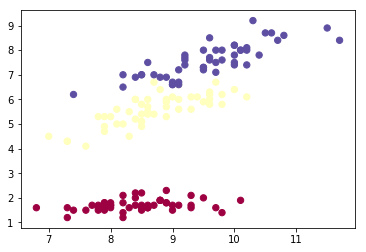

In [5]:
plt.scatter(X[:,0], X[:,1], c=Y, s=40, cmap=plt.cm.Spectral);

In [33]:
shape_X = X.shape
shape_Y = Y.shape


print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))

The shape of X is: (150, 2)
The shape of Y is: (150,)


In [163]:
Ym = np.zeros((Y.shape[0], len(set(Y))))
for (row, label) in zip(Ym, Y):
    row[label] = 1.0
    
Ym = Ym.T
Ym

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.,

/Users/mk/repos/inshorts-nlp/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mk/repos/inshorts-nlp/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


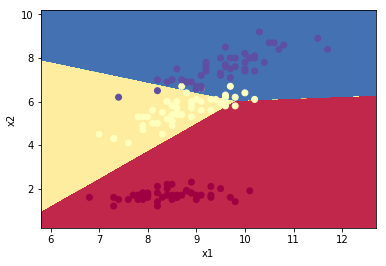

In [7]:
# Logistic regression try
import sklearn.linear_model

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X, Y);


# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X.T, Y.T)

In [164]:


def layers_sizes(X, Y, hidden_layers):
    """
    X -- input dataset
    Y -- labels
    hidden_layers -- vector of amounts of neurons in each hidden layer, 
                     i.e. [3,4,6] means 3 hidden layers with 3, 4 and 6 neurons accordingly
    
    Returns: array of layer sizes i.e. [34, 3, 4, 6, 2] (above example with 34 features and 2 labels dataset)
    """
    
    return [X.shape[1]] + hidden_layers + [Y.shape[0]]

layers_sizes(X, Ym, [3,4,5])
# expected [2,3,4,5,3]

[2, 3, 4, 5, 3]

In [165]:
np.random.seed(1)

def initialize_layers(layers_sizes):
    """
    layers_sizes -- array of sizes of each layes
    
    Returns: Array of weights for each layer. 
             Please note that the first layer takes the raw input - does not contain weights.
             Also, biases are excluded in this network.
    """
    result = []
    prev_size = layers_sizes[0]
    
    for size in layers_sizes[1:]:
        weights = np.random.randn(size, prev_size) * 0.01
        result += [weights]
        prev_size = size
    
    return result

initialize_layers([2,3,4])
# expected array of two matrices: 3x2 and 4x3 with random numbers

[array([[ 0.01624345, -0.00611756],
        [-0.00528172, -0.01072969],
        [ 0.00865408, -0.02301539]]),
 array([[ 0.01744812, -0.00761207,  0.00319039],
        [-0.0024937 ,  0.01462108, -0.02060141],
        [-0.00322417, -0.00384054,  0.01133769],
        [-0.01099891, -0.00172428, -0.00877858]])]

In [166]:
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

def forward_propagation(X, W):
    """
    X -- input dataset
    W -- list of matrices with weights
    
    Returns result of forward propagation (no_of_classes, no_of_examples) and cache with results of given layer
    """
    # input dataset is the output of the first layer
    A = X.T
    cache = [A]
    
    for w in W:
        Z = np.dot(w, A)
        A = sigmoid(Z)
        cache += [A]
        
    return A, cache

sizes = layers_sizes(X, Ym, [6])
layers = initialize_layers(sizes)
R, cache = forward_propagation(X, layers)
cache
# expected result: array 3x150 (3 classes, 150 examples)

[array([[ 8.6,  7.9,  7.9,  7.7,  8.6,  9.3,  8. ,  8.4,  7.3,  8. ,  9.1,
          8.2,  7.8,  7.3,  9.8, 10.1,  9.3,  8.6,  9.5,  8.9,  8.8,  8.8,
          8.2,  8.4,  8.2,  8. ,  8.4,  8.7,  8.6,  7.9,  7.9,  8.8,  9.3,
          9.7,  8. ,  8.2,  9. ,  8.5,  7.4,  8.5,  8.5,  6.8,  7.6,  8.5,
          8.9,  7.8,  8.9,  7.8,  9. ,  8.3, 10.2,  9.6, 10. ,  7.8,  9.3,
          8.5,  9.6,  7.3,  9.5,  7.9,  7. ,  8.9,  8.2,  9. ,  8.5,  9.8,
          8.6,  8.5,  8.4,  8.1,  9.1,  8.9,  8.8,  8.9,  9.3,  9.6,  9.6,
          9.7,  8.9,  8.3,  7.9,  7.9,  8.5,  8.7,  8.4,  9.4,  9.8,  8.6,
          8.6,  8. ,  8.1,  9.1,  8.4,  7.3,  8.3,  8.7,  8.6,  9.1,  7.6,
          8.5,  9.6,  8.5, 10.1,  9.2,  9.5, 10.6,  7.4, 10.2,  9.2, 10.8,
          9.7,  9.1,  9.8,  8.2,  8.6,  9.6,  9.5, 11.5, 10.3,  8.2, 10.1,
          8.4, 10.5,  9. , 10. , 10.4,  9. ,  9.1,  9.2, 10.2, 10.2, 11.7,
          9.2,  9.1,  8.7, 10.7,  9.7,  9.5,  9. , 10. ,  9.8, 10. ,  8.5,
         10. , 10. ,  9.7

In [167]:
def compute_cost(R, Y):
    """
    Arguments:
    R -- results of forward propagation (no_of_classes, no_of_examples)
    Y -- labels of exmples
    """
    
    m = Y.shape[1] # number of examples

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(R), Y) + np.multiply((1 - Y), np.log(1 - R))
    cost = - np.sum(logprobs) / m    
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    
    return cost

medium = compute_cost(
    np.array([[.1,.2,.3],
              [.4,.1,.4]]), 
    np.array([[0.,1.,0.],
              [1.,0.,1.]]))

big = compute_cost(
    np.array([[.1,.6,.3],
              [.8,.1,.6]]), 
    np.array([[1.,0.,1.],
              [0.,1.,0.]]))

small = compute_cost(
    np.array([[.1,.9,.1],
              [.9,.1,.9]]), 
    np.array([[0.,1.,0.],
              [1.,0.,1.]]))

small, medium, big

(0.2107210313156526, 1.336471783812265, 3.083720788832146)

In [169]:
def backward_propagation(W, cache, X, Y):
    """    
    Arguments:
    W -- list of matrices containing layers weights 
    cache -- list of vectors containing output of every layer
    X -- input dataset
    Y -- dataset labels
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[0]
    dZ = list(reversed(cache))[0] - Y
    gradients = []
    
    for (W, A) in zip(list(reversed(W)), list(reversed(cache))[1:]): 
        dW = (1/m) * np.dot(dZ, A.T)
        gradients = [dW] + gradients
        dZ = np.multiply(np.dot(W.T, dZ), 1 - np.power(A, 2))

    return gradients

# example for 2x2x1 neural network
backward_propagation(
    # 2 matrices with weights - 2x2 and 1x2
    [np.array([[1,2],[3,4]]), np.array([[1,2]])],
    # three vectors with output (the very first one is input dataset)
    [np.array([[1],[2]]), np.array([[1],[2]]), np.array([[3]])],
    # X
    np.array([[1,2]]),
    # Y
    np.array([[1]])
)
# should return two matrices with gradients corresponding to weights matrices sizes

[array([[  0.,   0.],
        [-12., -24.]]), array([[2., 4.]])]

In [170]:
def update_weights(W, gradients, learning_rate=1.2):
    result_W = []
    for (w, dW) in zip(W, gradients):
        w = w - learning_rate * dW
        result_W += [w]
    return result_W

update_weights(
    [np.array([[1,2],[3,4]]), np.array([[5]])],
    [np.array([[0,1],[2,3]]), np.array([[4]])],
    1)
# expected
# [[1,1],[1,1]], [1]

[array([[1, 1],
        [1, 1]]), array([[1]])]

In [176]:
def mlp_network(X, Y, iterations = 1000, hidden_layers=[10]):
    
    # TODO not hardcode parameters
    sizes = layers_sizes(X, Ym, hidden_layers)
    W = initialize_layers(sizes)
    
    for i in range(iterations):
        A, cache = forward_propagation(X, W)
        
        cost = compute_cost(A, Y)
        print('cost', i, cost)
        
        gradients = backward_propagation(W, cache, X, Y)
        
        W = update_weights(W, gradients)
    
    return W

optimal_W = mlp_network(X, Ym, 400, [10,20])

cost 0 2.080377471919424
cost 1 1.940391757346691
cost 2 1.912546582539516
cost 3 1.9098723768875334
cost 4 1.9095746308281316
cost 5 1.9095430857565157
cost 6 1.9095393394516111
cost 7 1.909538551948489
cost 8 1.9095380597321105
cost 9 1.9095375788774431
cost 10 1.9095370763702855
cost 11 1.909536546220639
cost 12 1.9095359849400317
cost 13 1.9095353891507785
cost 14 1.9095347552159097
cost 15 1.9095340791985784
cost 16 1.9095333568103248
cost 17 1.909532583368591
cost 18 1.9095317537445393
cost 19 1.9095308623055522
cost 20 1.9095299028493233
cost 21 1.9095288685289658
cost 22 1.9095277517674014
cost 23 1.9095265441593763
cost 24 1.9095252363590196
cost 25 1.9095238179505638
cost 26 1.9095222772993778
cost 27 1.9095206013799892
cost 28 1.9095187755771534
cost 29 1.9095167834553406
cost 30 1.9095146064911541
cost 31 1.909512223762225
cost 32 1.9095096115849455
cost 33 1.909506743092057
cost 34 1.909503587739502
cost 35 1.9095001107300902
cost 36 1.9094962723394049
cost 37 1.9094920271

/Users/mk/repos/inshorts-nlp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


cost 170 1.1819712188896192
cost 171 1.1376758834776945
cost 172 1.2311640359825524
cost 173 1.2006667355111964
cost 174 1.1966965721212761
cost 175 1.217437692543605
cost 176 1.1589068572339651
cost 177 1.1806869041209924
cost 178 1.144631121284673
cost 179 1.1734785024452647
cost 180 1.1518461773481354
cost 181 1.1599566574269786
cost 182 1.1624246335177726
cost 183 1.1737441313823755
cost 184 1.1697777129388345
cost 185 1.1864221437435412
cost 186 1.1829368747937834
cost 187 1.2265654258488694
cost 188 1.1691087182317035
cost 189 1.158493302866104
cost 190 1.162841364360997
cost 191 1.1428843291908164
cost 192 1.1339995220116088
cost 193 1.1152097594418668
cost 194 1.1278940403910918
cost 195 1.1125975100907117
cost 196 1.116002327112757
cost 197 1.0880507556584573
cost 198 1.1020754210683845
cost 199 1.0767647798319044
cost 200 1.0364184757433255
cost 201 1.0323076432913831
cost 202 1.033476870434473
cost 203 1.0303524813603235
cost 204 0.9883367212664085
cost 205 1.001947290551161

In [177]:
def predict(X, W):
    results = []
    R = forward_propagation(X, W)[0]
    print(R)
    for col in R.T:
        results += [col.argmax()]
    return results

predicted = predict(X, optimal_W)

[[9.30646629e-01 9.30646639e-01 9.30646503e-01 9.30646703e-01
  9.30646629e-01 9.30646751e-01 9.30646701e-01 9.30646698e-01
  9.30646648e-01 9.30646638e-01 9.30646693e-01 9.30646729e-01
  9.30646506e-01 9.30644315e-01 9.30646053e-01 9.30646740e-01
  9.30646691e-01 9.30646697e-01 9.30646748e-01 9.30646727e-01
  9.30646742e-01 9.30646742e-01 9.30644017e-01 9.30646753e-01
  9.30646752e-01 9.30646730e-01 9.30646749e-01 9.30646696e-01
  9.30646629e-01 9.30646730e-01 9.30646730e-01 9.30646742e-01
  9.30646617e-01 9.30646610e-01 9.30646701e-01 9.30646183e-01
  9.30646465e-01 9.30646483e-01 9.30646519e-01 9.30646697e-01
  9.30646630e-01 9.30646654e-01 9.30646512e-01 9.30646753e-01
  9.30646754e-01 9.30646702e-01 9.30646727e-01 9.30646641e-01
  9.30646694e-01 9.30646633e-01 1.09211605e-02 1.09211605e-02
  1.09211605e-02 1.09211605e-02 1.09211605e-02 1.09211605e-02
  1.09211605e-02 9.30646754e-01 1.09211605e-02 1.09211605e-02
  1.09211605e-02 1.09211605e-02 1.09211605e-02 1.09211605e-02
  9.3064

/Users/mk/repos/inshorts-nlp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [178]:
np.array(predicted)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [179]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])